Ordinal regression
--
Ordinal regression aims to fit a model to some data $(X, Y)$, where $Y$ is an ordinal variable. To do so, we use a `VPG` model with a specific likelihood (`gpflow.likelihoods.Ordinal`).

In [1]:
import gpflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

np.random.seed(123)  # for reproducibility

2022-03-08 09:30:21.951391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 09:30:21.951427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-03-08 09:30:24.564699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 09:30:24.564726: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 09:30:24.564747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4e08f62cd054): /proc/driver/nvidia/version does not exist
2022-03-08 09:30:24.565032: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0, 0.5, 'observed data value')

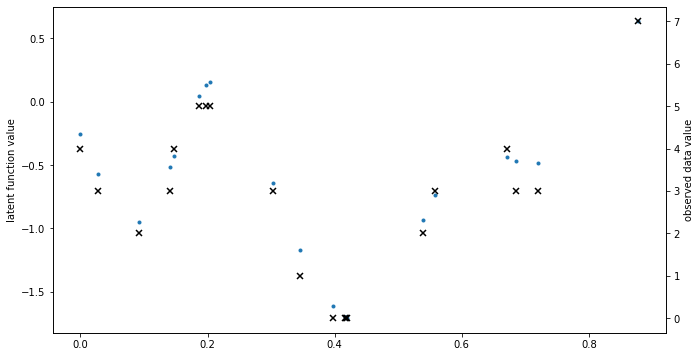

In [2]:
# make a one-dimensional ordinal regression problem

# This function generates a set of inputs X,
# quantitative output f (latent) and ordinal values Y


def generate_data(num_data):
    # First generate random inputs
    X = np.random.rand(num_data, 1)

    # Now generate values of a latent GP
    kern = gpflow.kernels.SquaredExponential(lengthscales=0.1)
    K = kern(X)
    f = np.random.multivariate_normal(mean=np.zeros(num_data), cov=K).reshape(-1, 1)

    # Finally convert f values into ordinal values Y
    Y = np.round((f + f.min()) * 3)
    Y = Y - Y.min()
    Y = np.asarray(Y, np.float64)

    return X, f, Y


np.random.seed(1)
num_data = 20
X, f, Y = generate_data(num_data)

plt.figure(figsize=(11, 6))
plt.plot(X, f, ".")
plt.ylabel("latent function value")

plt.twinx()
plt.plot(X, Y, "kx", mew=1.5)
plt.ylabel("observed data value")

In [3]:
# construct ordinal likelihood - bin_edges is the same as unique(Y) but centered
bin_edges = np.array(np.arange(np.unique(Y).size + 1), dtype=float)
bin_edges = bin_edges - bin_edges.mean()
likelihood = gpflow.likelihoods.Ordinal(bin_edges)

# build a model with this likelihood
m = gpflow.models.VGP(data=(X, Y), kernel=gpflow.kernels.Matern32(), likelihood=likelihood)

# fit the model
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

2022-03-08 09:30:24.795732: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-03-08 09:30:27.938103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


      fun: 25.487473830315576
 hess_inv: <233x233 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.70359248e-02, -2.70246931e-02, -3.66599294e-02, -4.26791405e-02,
       -6.32688152e-02, -2.90259169e-02, -6.92359005e-02, -5.63015644e-04,
       -1.26745465e-02,  2.07042794e-02,  5.13161917e-03,  1.45855389e-02,
        6.99264697e-03, -2.57649660e-02, -9.22087544e-03, -2.18851855e-02,
       -2.10240822e-04, -1.25013356e-02, -2.20989561e-02, -1.66336380e-03,
        2.76214266e-04, -4.08426285e-04, -5.74002152e-09,  2.48959271e-06,
       -1.86401657e-09, -7.60964304e-06,  1.96798952e-11, -6.41458883e-03,
        1.94977369e-08,  2.48885391e-06, -2.26202096e-07, -2.01864318e-05,
        1.53593920e-04, -3.33539937e-03,  2.67730686e-04,  6.05853576e-05,
        1.53125793e-04, -2.04837612e-04, -1.49517117e-04,  3.20367703e-04,
       -2.62424256e-02,  7.40782336e-03, -3.48529432e-09,  1.01918817e-06,
       -2.05151518e-10,  4.51035549e-04,  1.28703929e-11, -1.32289475e-03,

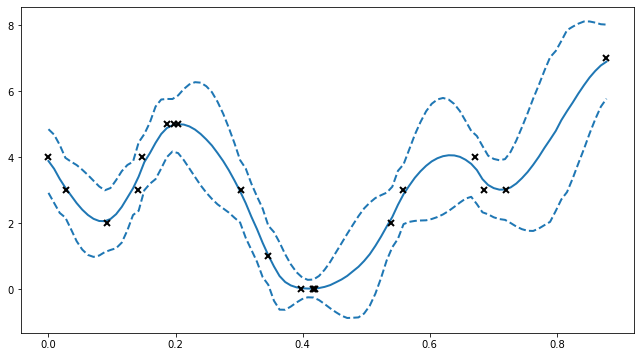

In [4]:
# here we'll plot the expected value of Y +- 2 std deviations, as if the distribution were Gaussian
plt.figure(figsize=(11, 6))
X_data, Y_data = (m.data[0].numpy(), m.data[1].numpy())
Xtest = np.linspace(X_data.min(), X_data.max(), 100).reshape(-1, 1)
mu, var = m.predict_y(Xtest)
(line,) = plt.plot(Xtest, mu, lw=2)
col = line.get_color()
plt.plot(Xtest, mu + 2 * np.sqrt(var), "--", lw=2, color=col)
plt.plot(Xtest, mu - 2 * np.sqrt(var), "--", lw=2, color=col)
plt.plot(X_data, Y_data, "kx", mew=2)

In [5]:
## to see the predictive density, try predicting every possible discrete value for Y.
def pred_log_density(m):
    Xtest = np.linspace(X_data.min(), X_data.max(), 100).reshape(-1, 1)
    ys = np.arange(Y_data.max() + 1)
    densities = []
    for y in ys:
        Ytest = np.full_like(Xtest, y)
        # Predict the log density
        densities.append(m.predict_log_density((Xtest, Ytest)))
    return np.vstack(densities)

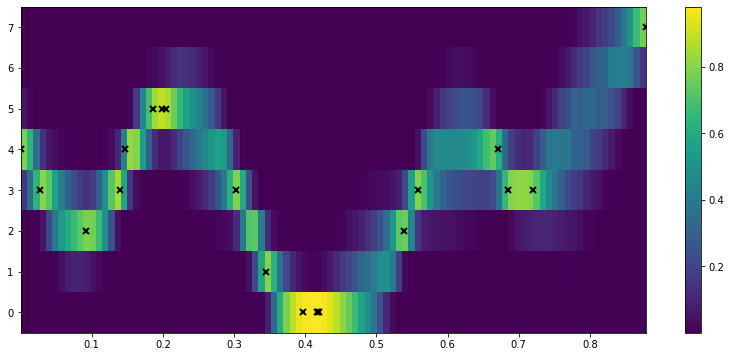

In [6]:
fig = plt.figure(figsize=(14, 6))
plt.imshow(
    np.exp(pred_log_density(m)),
    interpolation="nearest",
    extent=[X_data.min(), X_data.max(), -0.5, Y_data.max() + 0.5],
    origin="lower",
    aspect="auto",
    cmap=plt.cm.viridis,
)
plt.colorbar()
plt.plot(X, Y, "kx", mew=2, scalex=False, scaley=False)

<BarContainer object of 8 artists>

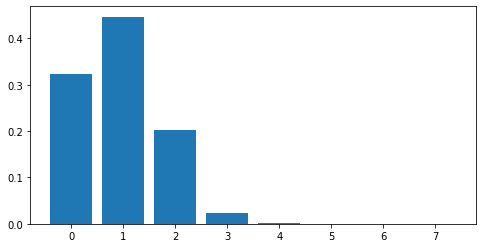

In [7]:
# Predictive density for a single input x=0.5
x_new = 0.5
Y_new = np.arange(np.max(Y_data + 1)).reshape([-1, 1])
X_new = np.full_like(Y_new, x_new)
# for predict_log_density x and y need to have the same number of rows
dens_new = np.exp(m.predict_log_density((X_new, Y_new)))
fig = plt.figure(figsize=(8, 4))
plt.bar(x=Y_new.flatten(), height=dens_new.flatten())